# **RECORDLINKAGE  TOOL**

### Required imports

In [1]:
import comet_ml
import recordlinkage
import pandas as pd

import numpy as np
import shapash
import mlxtend
import pickle
import random

import warnings; warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
#from shapash.explainer.smart_explainer import SmartExplainer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from codecarbon import EmissionsTracker
from lightgbm import LGBMClassifier
from recordlinkage import datasets
from comet_ml import Experiment
from PIL import Image


### Loading datasets 

In [2]:
org_dataset, dup_dataset = datasets.load_febrl4(return_links=False)

In [3]:
idx_org_dataset = sorted(org_dataset.index)
idx_dup_dataset = sorted(dup_dataset.index)
true_links = pd.MultiIndex.from_tuples(list(zip(idx_org_dataset, idx_dup_dataset)), names=('org_data', 'dpl_data'))

In [4]:
display(org_dataset)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688
rec-298-org,blake,howie,1,cutlack street,belmont park belted galloway stud,budgewoi,6017,vic,19250301,5180548
rec-1985-org,NaN,lund,109,caley crescent,allandale aged care facility,mill park,4053,nsw,19180902,7074690
rec-2404-org,blakeston,broadby,53,traeger street,valley of springs,north ward,3083,qld,19120907,4308555
rec-1473-org,NaN,leslie,925,carpenter close,NaN,canterbury,2340,vic,19950608,2438058


## **PREPROCESSING**

Recordlinkage propose un étape de préprocessing. Nous ne l'utilisons pas ici car les données utilisées sont déjà pré processées. 

## **INDEXATION**

L'indexation n'est faisable que sur **un** ou **deux** jeu de données. 4 méthodes d'indexations sont proposées par l'outil:
- Full : renvoie toutes les combinaisons de paires possibles
- Block : renvoie toutes les lignes ayant des valeurs égales sur une ou plusieurs des colonnes données en entrée 
- SortedNeighbourhood : renvoie les paires ayant des valeurs similaires sur une ou plusieurs des colonnes données en entrée et celles dans leur voisinnage
- Random : renvoie des paires crées aléatoirement

Ici, nous testons les méthodes **block** et **SortedNeighbourhood** en utilisant les colonnes 'given_name', 'address_1' et 'date_of_birth'. 

### **1. Méthode de blocage**

In [5]:
def block_indexing(blocking_key: list, original_dataset: pd.DataFrame, duplicate_dataset: pd.DataFrame, true_links:pd.MultiIndex) -> pd.MultiIndex :
    """
    Simple function that use block indexation from recordlinkage.
    
    Make candidate pairs, from original_dataset and duplicate_dataset, that agree on one or more variables 
    of blocking_key parameter. Returns all pairs founded.
    
    
    Parameters:
    -----------
        blocking_key (list) : A list of variables in which block method is made
        original_dataset (pandas.DataFrame) : A dataframe containing at least blocking_key variables in columns
        duplicate_dataset (pandas.DataFrame) : A dataframe containing at least blocking_key variables in columns
        true_links (pandas.MultiIndex) : MultiIndex of indexes' paire of candidtates, from between original_dataset 
        and duplicate_dataset, which are same 
    
    Return:
    --------
        pairs : pandas.MultiIndex with record pairs founded
    """
    
    indexer = recordlinkage.Index()
    for key in blocking_key:
        indexer.block(on=key)
        pairs = indexer.index(original_dataset, duplicate_dataset)
        real_links_found = pairs & true_links
        perc_real_links_found = len(real_links_found)/len(true_links)*100
        print("Nombre de paires sélectionnées: {}".format(len(pairs)))
        print("Pourcentage de vraies paires selctionnées: {}%. \n".format(perc_real_links_found))
    return pairs

Pour évaluer les résultats de la méthode d'indexation utilisée, nous regardons deux élements:
- le pourcentage de paires dupliquées detectées
- la performance de la méthode en fonction du nombre de clé de blockage utilisée


In [6]:
candidates_pairs_block = block_indexing(['given_name', 'address_1', 'date_of_birth'], org_dataset, dup_dataset, true_links)

Nombre de paires sélectionnées: 77249
Pourcentage de vraies paires selctionnées: 65.74%. 

Nombre de paires sélectionnées: 85758
Pourcentage de vraies paires selctionnées: 87.42%. 

Nombre de paires sélectionnées: 86959
Pourcentage de vraies paires selctionnées: 98.72%. 



L'étape d'indexation est cruciale. **Plus on donne d'informations (précises) en entrée, meilleure est la précision selection de paires de candidats à comparer.** 

#### **Ressemblance des paires selectionnées**

Le processus de recherche des clés peut être effectuée de manière itérative, en examinant manuellement la sortie du blocage et en réglant la clé jusqu'à ce que la précision requise soit atteinte.

In [7]:
 def selected_pairs_values(idx_pairs, original_dataset: pd.DataFrame, duplicate_dataset: pd.DataFrame):
        
    """
    Select row from orgine_dataset and duplicate_dataset matching with indexes in idx_pairs then return those
    rows concatenate in a dataframe.
    """
    candidates = pd.DataFrame(columns=original_dataset.columns)
    for tpl in idx_pairs:
        tmp_fst = original_dataset.iloc[original_dataset.index.isin([tpl[0]])]
        tmp_scd = duplicate_dataset.iloc[duplicate_dataset.index.isin([tpl[1]])]
        concat_tmp = pd.concat([tmp_fst, tmp_scd])
        candidates = pd.concat([candidates, concat_tmp])
        
    return candidates 

### **2. Méthode du SortedNeighborhood**

Dans le cas ou les données sont susceptible de contenir des erreurs de typographies, utiliser la méthode SortedNeighborhood peut ajouter une certaine flexibilité pour les fautes d'orthographe mineures. 

In [8]:
def sorted_neighbourhood_indexing(sn_key: list, original_dataset: pd.DataFrame, duplicate_dataset: pd.DataFrame, true_links: pd.MultiIndex) -> pd.MultiIndex:
    """
    Simple function that use sorted neighbourhood indexation from recordlinkage package.
    
    Make candidate record pairs, from original_dataset and duplicate_dataset, that agree on one or more variables 
    of sn_key parameter. Returns all record pairs founded.
    
    Parameters:
    -----------
        sn_key (list) : A list of variables 
        original_dataset (pandas.DataFrame) : A dataframe containing at least blocking_key variables 
        duplicate_dataset (pandas.DataFrame) : A dataframe containing at least blocking_key variables
        true_links (pandas.MultiIndex) :  MultiIndex of indexes' paire of candidtates, from between original_dataset 
        and duplicate_dataset, which are same 
        
    Return:
    --------
        pairs : pandas.MultiIndex with record pairs founded
    """
    
    for key in sn_key:
        indexer = recordlinkage.SortedNeighbourhoodIndex(key)
        pairs = indexer.index(org_dataset, dup_dataset)
        real_links_found = pairs & true_links
        print("Nombre de paires sélectionnées: {}".format(len(pairs)))
        perc_real_links_found = len(real_links_found)/len(true_links)*100
        print("Pourcentage de vraies paires selctionnées: {}%.\n".format(perc_real_links_found))
        
    return pairs

In [9]:
candidates_pairs_sn = sorted_neighbourhood_indexing(['given_name', 'address_1', 'date_of_birth'], org_dataset, dup_dataset, true_links)

Nombre de paires sélectionnées: 96573
Pourcentage de vraies paires selctionnées: 71.26%.

Nombre de paires sélectionnées: 21383
Pourcentage de vraies paires selctionnées: 83.86%.

Nombre de paires sélectionnées: 14770
Pourcentage de vraies paires selctionnées: 89.48%.



## **COMPARAISON**

La méthode suivante consiste à comparer les paires en utilisant *Compare*.
Nous pouvons définir plusieurs options pour la façon dont nous voulons comparer les colonnes de données.

In [10]:
def comparison_scores(attr: list, candidate_pairs: pd.MultiIndex, original_dataset: pd.DataFrame, duplicate_dataset: pd.DataFrame, method:list=None) -> pd.DataFrame:
    
    """
    Compare the attributes of candidate record pairs candidate_pairs and return scores comparison 
    returned by .compute() method from recordlinkage.
    
    
    Parameters:
    -----------
        attr (list) : List of attributes to compare
        candidate_pairs (pandas.MultiIndex) :  MultiIndex with index of candidates pairs to compare 
        original_dataset (pandas.DataFrame) : A dataframe containing at least feature_to_comp  
        duplicate_dataset (pandas.DataFrame) :  A dataframe containing at least feature_to_comp 
        method (list) : list of method (jarowinkler, leveinshtein, etc) to use for comparison
        
    Return:
    --------
        scores (pandas.DataFrame) : A DataFrame with the comparison scores vectors
    """
    
    if method is None:
        method = ['jarowinkler']*len(attr)
    
    compare = recordlinkage.Compare()
    # initialise similarity measurement algorithms
    for i in range(len(attr)): 
        compare.string(attr[i], attr[i], label=attr[i]+'_score', method=method[i])

    # the method .compute() returns the DataFrame with the feature vectors.
    scores = compare.compute(candidate_pairs, original_dataset, duplicate_dataset)
    
    return scores

In [11]:
scores = comparison_scores(['given_name', 'surname', 'address_1', 'soc_sec_id'], candidates_pairs_block, org_dataset, dup_dataset)

### **CLASSIFICATION & CODE CARBON**

Les vecteurs de scores de similarités sont donnés en entrée au classifieur (supervisé ou non supervisé). 

In [12]:
def add_label(scores: pd.DataFrame, true_links: pd.MultiIndex)-> pd.DataFrame :
    """
    Generate two new columns :
        - tupled_index : concatenation of scores dataframe index
        - label : 1 if the candidate pair is a real match, 0 otherwise
    And then drop column tupled_index
        
    Parameters:
    -----------
        scores (pandas.DataFrame) : A DataFrame with scores vectors 
        true_links (pandas.MultiIndex) :  MultiIndex of indexes' paire of candidtates, from between original_dataset 
        and duplicate_dataset, which are same 
        and duplicate_dataset, which are same 
        
    Return:
    -----------
        score_with_label (pandas.DataFrame) : A dataframe containing 1 new column 'label'
    """
    
    score_with_label = scores.copy()
    score_with_label['tupled_index'] = score_with_label.index.tolist()
    score_with_label['label'] = score_with_label['tupled_index'].apply(lambda x: 1 if x in true_links else 0)
    score_with_label = score_with_label.drop('tupled_index', axis=1, inplace=False)
    
    return score_with_label

In [13]:
comparison_scores = add_label(scores, true_links)

In [14]:
comparison_scores

given_name_score  surname_score  address_1_score  \
rec_id_1    rec_id_2                                                           
rec-0-org   rec-0-dup-0             1.000000       1.000000         1.000000   
            rec-1230-dup-0          0.595238       0.407407         1.000000   
            rec-2323-dup-0          1.000000       0.000000         0.521687   
            rec-254-dup-0           0.000000       0.500000         1.000000   
            rec-3625-dup-0          0.714286       0.000000         1.000000   
            rec-3657-dup-0          1.000000       0.472222         0.537229   
            rec-4514-dup-0          1.000000       0.483333         0.579846   
            rec-501-dup-0           0.447619       0.000000         1.000000   
rec-1-org   rec-1-dup-0             1.000000       1.000000         0.960000   
            rec-1168-dup-0          1.000000       0.000000         0.761111   
            rec-1215-dup-0          1.000000       0.436508         0.770794   
            rec-1261-dup-0          1.000000       0.495238         0.477778   
            rec-1416-dup-0          1.000000       0.465079         0.516667   
            rec-1583-dup-0          1.000000       0.619048         0.524242   
            rec-1601-dup-0          1.000000       0.464286         0.378431   
            rec-170-dup-0           1.000000       0.465079         0.494444   
            rec-1751-dup-0          1.000000       0.000000         0.478571   
            rec-1846-dup-0          1.000000       0.000000         0.000000   
            rec-1856-dup-0          1.000000       0.539683         0.576068   
            rec-198-dup-0           1.000000       0.428571         0.485897   
            rec-205-dup-0           1.000000       0.373016         0.778788   
            rec-2059-dup-0          1.000000       0.492063         0.537500   
            rec-2085-dup-0          1.000000       0.490079         0.000000   
            rec-2153-dup-0          1.000000       0.357143         0.478571   
            rec-225-dup-0           1.000000       0.000000         0.572222   
            rec-3144-dup-0          1.000000       0.000000         0.459259   
            rec-3583-dup-0          1.000000       0.000000         0.544444   
            rec-3629-dup-0          1.000000       0.422619         0.546617   
            rec-3772-dup-0          1.000000       0.000000         0.478571   
            rec-3953-dup-0          1.000000       0.000000         0.704762   
...                                      ...            ...              ...   
rec-998-org rec-998-dup-0           1.000000       0.966667         1.000000   
rec-999-org rec-1098-dup-0          1.000000       0.000000         0.794444   
            rec-1263-dup-0          1.000000       0.000000         0.572685   
            rec-1359-dup-0          1.000000       0.000000         0.727066   
            rec-1879-dup-0          1.000000       0.458333         0.473203   
            rec-2060-dup-0          1.000000       0.000000         0.809380   
            rec-2570-dup-0          1.000000       0.464286         0.544444   
            rec-2878-dup-0          1.000000       0.000000         0.767407   
            rec-3094-dup-0          1.000000       0.000000         0.473203   
            rec-3098-dup-0          1.000000       0.000000         0.543434   
            rec-3138-dup-0          1.000000       0.444444         0.563889   
            rec-3207-dup-0          1.000000       0.595238         0.779076   
            rec-3263-dup-0          1.000000       0.611111         0.415278   
            rec-3408-dup-0          0.600000       0.458333         1.000000   
            rec-3508-dup-0          1.000000       0.000000         0.672222   
            rec-3724-dup-0          1.000000       0.464286         0.539484   
            rec-3750-dup-0          1.000000       0.000000         0.537374   
            rec-3791-dup-0  

In [15]:
train, test = train_test_split(comparison_scores, test_size=0.25)
X_train = train.drop('label', axis=1, inplace=False)
X_test = test.drop('label', axis=1, inplace=False)
y_train = train['label']
y_test = test['label']

In [17]:
def fit_and_track(project_name: str, clf, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame):
    """
    Train and fit the classifier clf with X_train, X_test and y_train and calculate carbon emissions 
    using EmissionsTracker from codecarbon
    
    Parameters:
    -----------
        project_name (str) : Name of the project for EmissionTracker function
        X_train (pandas.DataFrame) : A DataFrame for training
        X_test (pandas.DataFrame) : A DataFrame for test
        y_train (pandas.DataFrame) : A DataFrame for training
        
    Return:
    -----------
        predictions (numpy.array) : Array of predicted values
        
    """
    tracker = EmissionsTracker(project_name=project_name)
    tracker.start()

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    predictions = pd.DataFrame(data=predictions, index=X_test.index, columns=['label'])
    
    tracker.stop()
    
    return predictions

In [18]:
classifier = LGBMClassifier()
predictions = fit_and_track("tdf_innovation", classifier, X_train, X_test, y_train)

In [19]:
code_carbon_res = Image.open('illustration/cocdecarbon_vis.png')

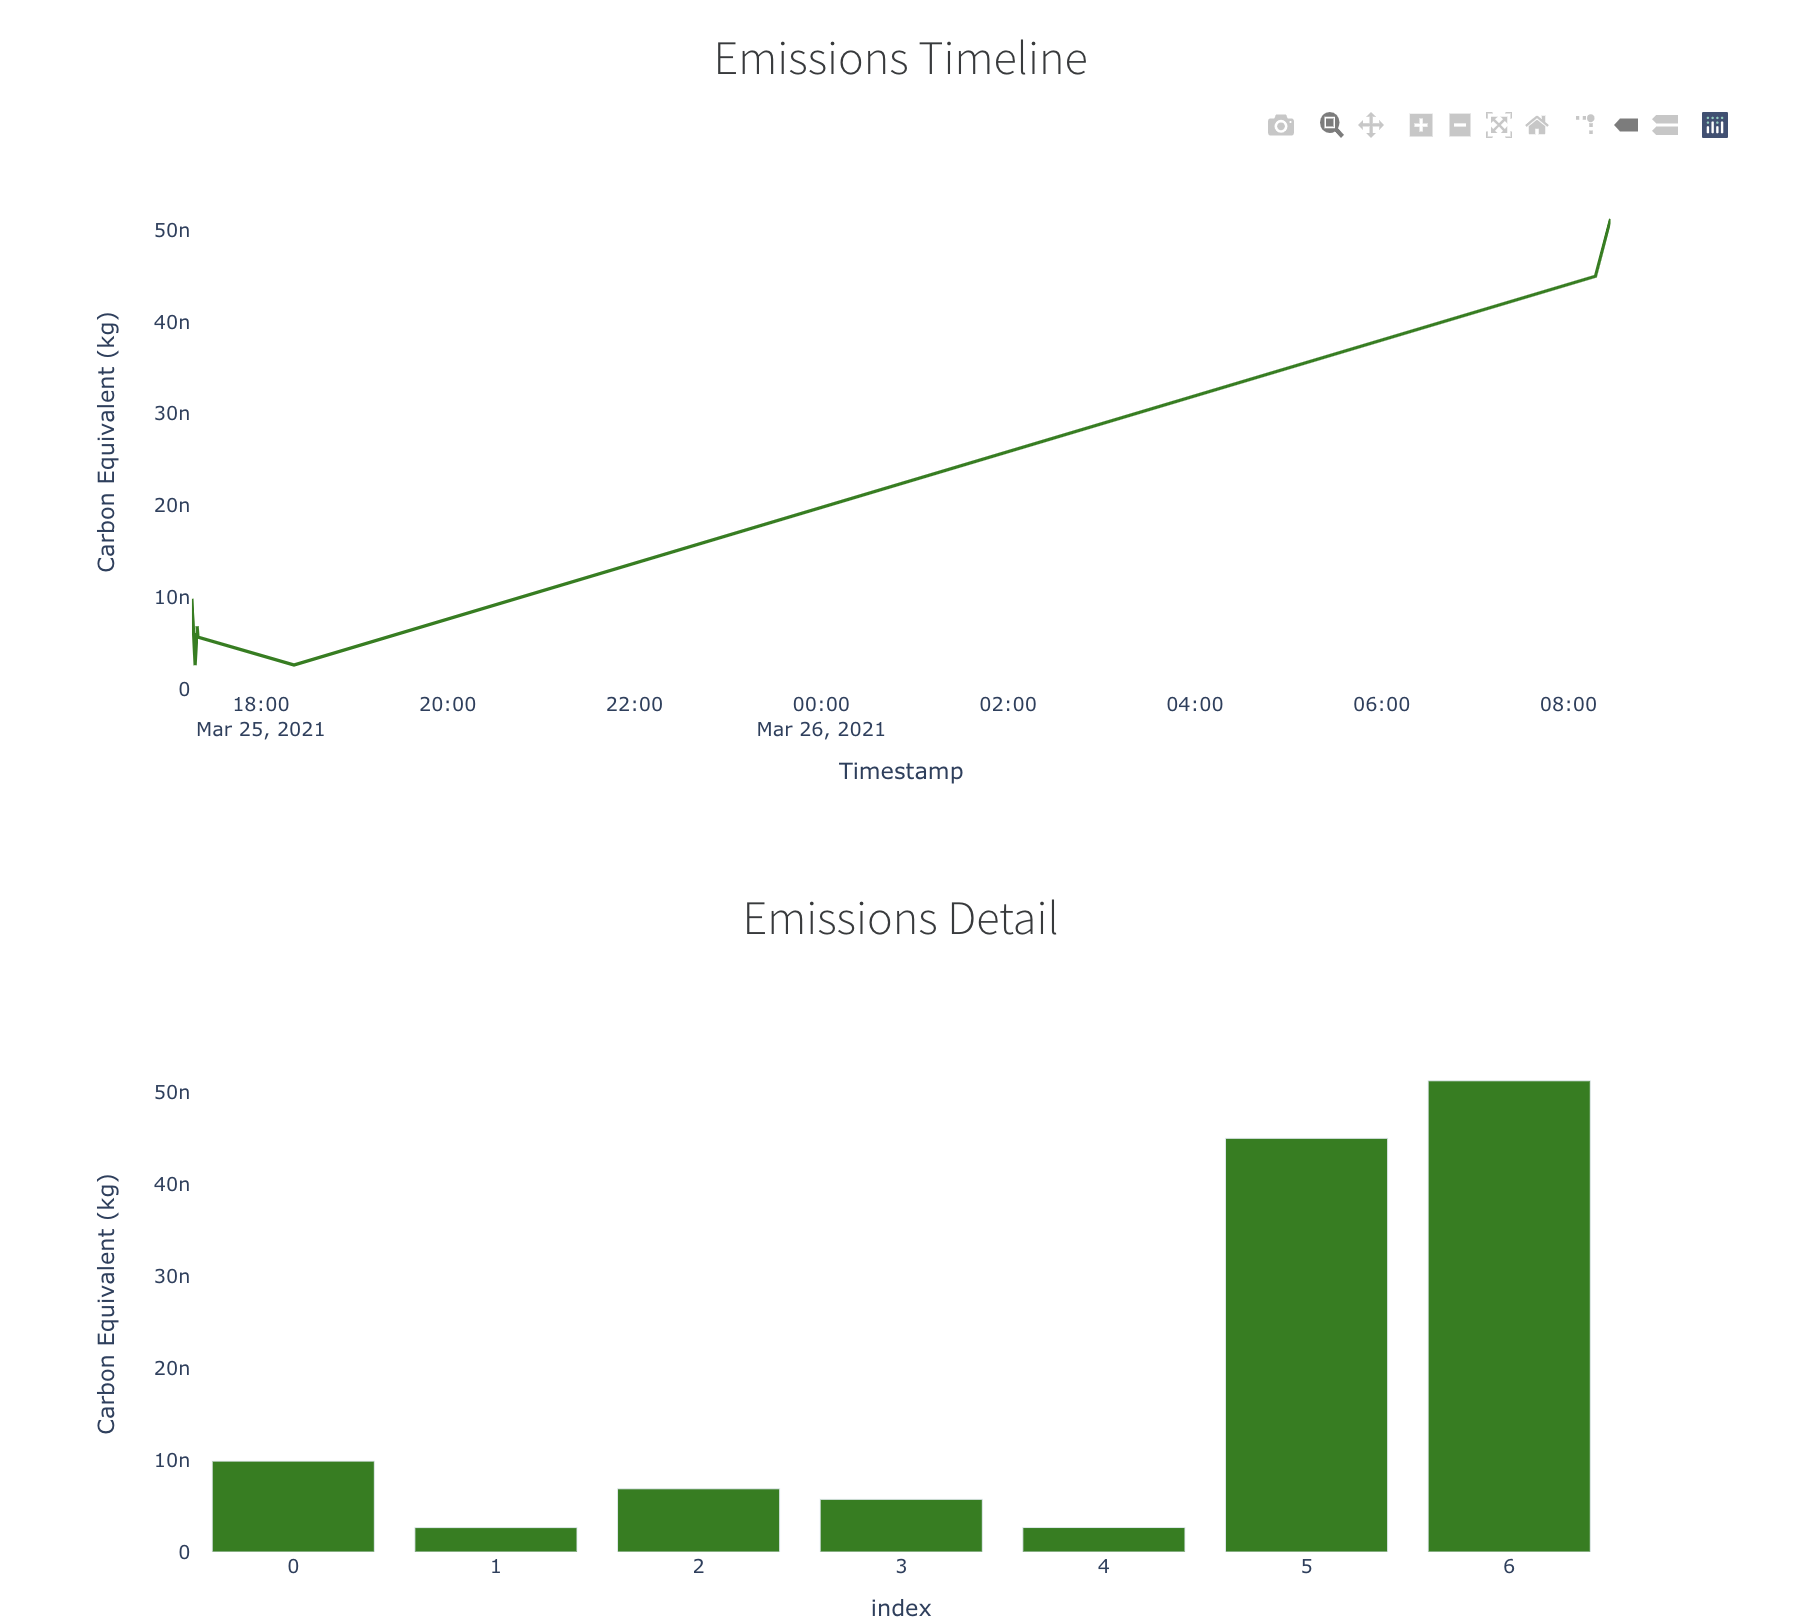

In [20]:
code_carbon_res

## EVALUATION 

Pour évaluer le modèle de classification, nous utilisons les méthodes d'évaluation de performance habituelles.

In [21]:
def evaluation(Y_test: pd.DataFrame, predictions: pd.DataFrame):
    """
    Compute standard evaluation functions (recall, precision, accuracy) and plot confusion matrix.
    """
    recall = recall_score(Y_test, predictions['label'])
    precision = precision_score(Y_test, predictions['label'])
    accuracy = accuracy_score(Y_test, predictions['label'])
    
    print("Rappel: {}".format(recall))
    print("Precision: {}".format(precision))
    print("Accuracy: {}".format(accuracy))
    print("0: match \n1: non match")
    plot_confusion_matrix(confusion_matrix(Y_test, predictions))
    
    return recall, precision, accuracy

Rappel: 0.9876135425268373
Precision: 0.998330550918197
Accuracy: 0.9992180312787489
0: match 
1: non match


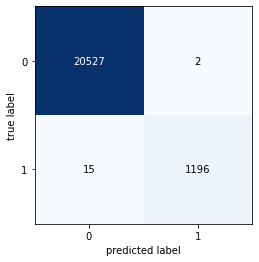

In [22]:
recall, precision, accuracy = evaluation(y_test, predictions)

**Visualisation des erreurs: faux positifs et faux négatifs**

In [66]:
select_candidates_from_false_prediction(predictions, true_links, org_dataset, dup_dataset, True)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688
rec-298-org,blake,howie,1,cutlack street,belmont park belted galloway stud,budgewoi,6017,vic,19250301,5180548
rec-2404-org,blakeston,broadby,53,traeger street,valley of springs,north ward,3083,qld,19120907,4308555
rec-1473-org,NaN,leslie,925,carpenter close,NaN,canterbury,2340,vic,19950608,2438058
rec-453-org,edward,denholm,10,corin place,gold tyne,clayfield,4221,vic,19660306,7119771
rec-4866-org,charlie,alderson,266,hawkesbury crescent,deergarden caravn park,cooma,4128,vic,19440908,1256748


## **HUMAN REVIEW**

In [65]:
def select_candidates_from_false_prediction(predictions: pd.DataFrame, true_links:pd.MultiIndex,
                                            original_dataset: pd.DataFrame, duplicate_dataset: pd.DataFrame, test:pd.DataFrame,
                                            false_positive=True):
    
    """
    Select false positive (or true positive) candidate predicted and return a dataframe with these candidate.
    
    Parameters:
    -----------
        predictions (pd.MutliIndex) : 
        true_links (pandas.MultiIndex) :  MultiIndex of indexes' paire of candidtates, from between original_dataset 
        and duplicate_dataset, which are same 
        original_dataset (pandas.DataFrame) :  A dataframe containing at least feature_to_comp
        duplicate_dataset (pandas.DataFrame) :  A dataframe containing at least feature_to_comp
        test (pandas.DataFrame) :  DataFrame used to train the classifer
        false_positive (bool) : prediction to select 
    
    Return:
    -----------
        (pandas.DataFrame) : A dataframe with false positive (or false negatif)
    """
    
    if false_positive:
        match_prediction = predictions[predictions['label'] == 1]
        false = list(set(match_prediction.index.values) - set(true_links.values))
        false = list(zip(*false))
    else:
        non_match_prediction =  predictions[predictions['label'] == 0]
        false = list(set(true_links.values) - set(non_match_prediction.index.values))
        false = list(zip(*false)) # format change
    
    candidate_fst_idx = original_dataset.iloc[original_dataset.index.isin(false[0])]
    candidate_scd_idx = duplicate_dataset.iloc[duplicate_dataset.index.isin(false[1])]
    
    return pd.concat([candidate_fst_idx, candidate_scd_idx])

La dernière étape est la revue humaine. Pour l'accompagner, nous utilisons l'outil shapash, qui est un outil de visualisation.

In [ ]:
features = {
     'given_name_score': 'given_name_score',
     'surname_score': 'surname_score',
     'address_1_score': 'address_1_score',
     'soc_sec_id_score': 'soc_sec_id_score'
}
interpretable_train = X_train

In [ ]:
def explain(X_test: pd.DataFrame,  y_test: pd.DataFrame, classifier: object, features: dict):
    """
    Parameters:
    -----------
        X_test (pd.DataFrame) : DataFrame used to train classifier
        y_test (pd.DataFrme) : DataFrame used to train classifier
        features (dict) : Features present in DataFrame
        classifier (object) : classifier used to make prediction 
        
    Return: 
    -----------
        xpl (object) : SmartExplainer 
    """
    
    xpl = SmartExplainer(features_dict=features) # optional parameter
    xpl.compile(
        x=X_test,
        model=classifier,
        y_pred= y_test
    )
    return xpl 

In [ ]:
explainer = explain(X_test, y_test, classifier, features)

#### **FEATURES IMPORTANCES**

In [ ]:
explainer.plot.features_importance()

#### **FEATURE CONTRIBUTION**

In [ ]:
explainer.plot.contribution_plot(col='address_1_score')

In [ ]:
app = explainer.run_app(title_story='Dupliacte Matches')

In [ ]:
app.kill()

## **META DONNÉES**

In [ ]:
interpretability_meta_data_model = {
    'model_version' : 'test',
    'features': features,
    'interpretable_model_train' : X_test,
    'model_to_interprete' : classifier,
    'prediction_to_mimic' : y_test
}

In [ ]:
print("Meta data model:\n\n", interpretability_meta_data_model)

In [ ]:
deduplication_pipeline = {
    'first_dataset_shape' : org_dataset.shape,
    'second_dataset_shape' : dup_dataset.shape,
    'indexing_method' : 'block',
    'columns_used_for_indexing' : ['given_name', 'address_1', 'date_of_birth'],
    'columns_compared' : ['given_name', 'surname', 'address_1', 'soc_sec_id'],
    'string_method_used_for_comp' : {'given_name':'jarowinckler', 'surname':'jarowinckler','address_1':'levenshtein'},
    'model_classification' : 'LGBMClassifier',
    'train_size' : train.shape[0],
    'test_size' : test.shape[0],
    'recall_score' : recall,
    'precision' : precision,
    'accuracy' : accuracy,
}

In [ ]:
print("Deduplication pipelin metadata:\n\n", deduplication_pipeline)

In [ ]:
print("Deduplication pipeline meta data:\n\n")
deduplication_pipeline

In [ ]:
emissions = pd.read_csv('emissions.csv').iloc[-1:, :][['duration', 'emissions', 'energy_consumed']].to_dict()

In [ ]:
print("Emissions meta data:\n\n", emissions)